In [42]:
import import_ipynb
from functionsModel import rank_keywords # Similarities using keywords
from functionsModel import rank_embeddings # Similarities using word embeddings
from preprocessText import preprocess_text # Function to process the text

import json
import pandas as pd

from tabulate import tabulate
import time

import gensim.downloader as api
from pytorch_pretrained_bert import BertTokenizer, BertModel

import matplotlib.pyplot as plt
import random

# Load & Preprocess Tables

In [48]:
with open('Data/Evaluation/WikiTables/tables_redi2_1/re_tables-0001.json', 'r') as f:
  file = json.load(f)

In [47]:
random_30_tables = random.sample(file.items(), 30)

C:\Users\User\AppData\Local\Temp\ipykernel_53176\2062197513.py:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_30_tables = random.sample(file.items(), 30)


In [49]:
# Create data lake from the tables in the json file
data_lake = []
data_lake_captions = []
data_lake_pages = []
for table_name, table_data in random_30_tables:
    table_caption = table_data.get('caption')
    table_page = table_data.get('pgTitle')
    table_values = table_data.get('data')
    table_text = []
    for row in table_values:
        row_text = '. '.join(str(v) for v in row)
        table_text.append(row_text)
    table_text = '. '.join(table_text)
    data_lake.append(table_text)
    data_lake_captions.append(table_caption)
    data_lake_pages.append(table_page)

In [18]:
# Preprocess text of the table in the data lake
data_lake_clean = [preprocess_text(table) for table in data_lake]

In [19]:
# Filter out tables with no text
data_lake_filtered = []
data_lake_indexes_filtered = []
for i,table_text in enumerate(data_lake_clean):
    if table_text != '':
        data_lake_filtered.append(table_text)
        data_lake_indexes_filtered.append(i)

In [20]:
def originalIndexes(filtered_indexes, list_original_indexes):
    original_indexes = []
    for index in filtered_indexes:
        original_indexes.append(list_original_indexes[index])
    return original_indexes

In [74]:
# Load query table
queries = pd.read_csv('Data/Evaluation/WikiTables/queries.csv', header=None)
queries = queries[0].to_list()

query_number = 12
query = queries[query_number]
query_file_number = query[6:10]

query_file = 'Data/Evaluation/WikiTables/tables_redi2_1/re_tables-' + query_file_number + '.json'

with open(query_file, 'r') as f:
  file = json.load(f)

for table_name, table_data in file.items():
  if table_name == query:
    query_caption = table_data.get('caption')
    query_page = table_data.get('pgTitle')
    query_values = table_data.get('data')
    query_text = []
    for row in query_values:
      row_text = '. '.join(str(v) for v in row)
      query_text.append(row_text)
    query_text = '. '.join(query_text)

if query_text == []:
     print("Table not found")

In [ ]:
# Preprocess the text of the query table
query_text_clean = preprocess_text(query_text)

# Run models on the input tables

In [23]:
def printResultsWikiTables(indexes, similarities, data_lake_captions, data_lake_pages, keywordExtractionMethod, embeddingsMethod = None):
    # Funtion to print the output list of top-k most similar tables in a readible way
    print("Keyword extraction method: {}".format(keywordExtractionMethod))
    if embeddingsMethod is not None:
        print("Embeddings method: {}".format(embeddingsMethod))

    print("-----")

    captions = [data_lake_captions[i] for i in indexes]
    pages = [data_lake_pages[i] for i in indexes]
    table = pd.DataFrame({'Index': indexes, 'Table Caption' : captions, 'Page Title' : pages, 'Similarity': similarities}) 
    print(tabulate(table, headers=['Index', 'Table Caption', 'Page Title', 'Similarity']))

## Load required models

In [24]:
# Word2Vec
model_Word2Vec = api.load("word2vec-google-news-300")

# BERT
model_name_Bert = 'bert-base-uncased'
tokenizer_Bert = BertTokenizer.from_pretrained(model_name_Bert)
model_Bert = BertModel.from_pretrained(model_name_Bert)
model_Bert.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (den

## Run models

LDA

In [25]:
start_time = time.time()

keywordExtractionMethod = 'lda'

rank_lda_filtered, rank_lda_similarities = rank_keywords(query_text_clean, data_lake_filtered, keywordExtractionMethod, k=10)
rank_lda_indexes = originalIndexes(rank_lda_filtered, data_lake_indexes_filtered)
printResultsWikiTables(rank_lda_indexes, rank_lda_similarities, data_lake_captions, data_lake_pages, keywordExtractionMethod)

print("-----")
running_time_lda = time.time() - start_time
print("Running time: %s seconds" % round(running_time_lda,2))

Keyword extraction method: lda
-----
      Index  Table Caption           Page Title                               Similarity
--  -------  ----------------------  -------------------------------------  ------------
 0      654  Awards and nominations  Sierra Boggess                            0.0410959
 1      276  N                       List of Murder, She Wrote guest stars     0.0273973
 2      428  Iron Cross              Iron Cross                                0.027027
 3      395  Awards                  Chance Phelps                             0.027027
 4       71  1974                    Deram Records                             0.027027
 5      538  Iron Cross              Iron Cross                                0.027027
 6      555  EPs and Singles         Acrimony                                  0.027027
 7       21  Iron Cross              Iron Cross                                0.027027
 8      740  Lubrication             Reamer                                    

YAKE

In [26]:
start_time = time.time()

keywordExtractionMethod = 'yake'

rank_yake_filtered, rank_yake_similarites = rank_keywords(query_text_clean, data_lake_filtered, keywordExtractionMethod, k=10)
rank_yake_indexes = originalIndexes(rank_yake_filtered, data_lake_indexes_filtered)
printResultsWikiTables(rank_yake_indexes, rank_yake_similarites, data_lake_captions, data_lake_pages, keywordExtractionMethod)

print("-----")
running_time_yake = time.time() - start_time
print("Running time: %s seconds" % round(running_time_yake,2))

Keyword extraction method: yake
-----
      Index  Table Caption    Page Title                Similarity
--  -------  ---------------  ----------------------  ------------
 0       21  Iron Cross       Iron Cross                 0.0771581
 1      428  Iron Cross       Iron Cross                 0.0639391
 2      538  Iron Cross       Iron Cross                 0.0563513
 3      740  Lubrication      Reamer                     0.0469693
 4      555  EPs and Singles  Acrimony                   0.0459215
 5      717  Studio albums    Pat Green                  0.0422988
 6       30  North America    Bewitched DVD releases     0.0400209
 7      882  Branches         Abdominal aorta            0.0207699
 8      395  Awards           Chance Phelps              0.0201707
 9      440  Jack & Jill      Rina Mimoun                0.0194725
-----
Running time: 10.94 seconds


LDA + Word2Vec

In [27]:
start_time = time.time()

keywordExtractionMethod = 'lda'
embeddingsMethod = 'word2vec'

rank_lda_word2vec_filtered, rank_lda_word2vec_similarities = rank_embeddings(query_text_clean, data_lake_filtered, keywordExtractionMethod, embeddingsMethod, model_Word2Vec, k = 10)
rank_lda_word2vec_indexes = originalIndexes(rank_lda_word2vec_filtered, data_lake_indexes_filtered)
printResultsWikiTables(rank_lda_word2vec_indexes, rank_lda_word2vec_similarities, data_lake_captions, data_lake_pages, keywordExtractionMethod, embeddingsMethod)

print("-----")
running_time_lda_word2vec = time.time() - start_time
print("Running time: %s seconds" % round(running_time_lda_word2vec,2))

Keyword extraction method: lda
Embeddings method: word2vec
-----
      Index  Table Caption                        Page Title                                                                 Similarity
--  -------  -----------------------------------  -----------------------------------------------------------------------  ------------
 0      303  Winners and nominees                 Daytime Emmy Award for Outstanding Younger Actor in a Drama Series         0.00635196
 1      562  Winners and nominees                 Daytime Emmy Award for Outstanding Supporting Actor in a Drama Series      0.00635196
 2      286  Track listing                        Takers and Leavers                                                         0.00573791
 3      692  Concept                              White City: A Novel                                                        0.00573791
 4      758  Winners and nominees                 Daytime Emmy Award for Outstanding Younger Actress in a Drama Series 

LDA + BERT

In [28]:
start_time = time.time()

keywordExtractionMethod='lda'
embeddingsMethod = 'bert'

rank_lda_bert_filtered, rank_lda_bert_similarities = rank_embeddings(query_text_clean, data_lake_filtered, keywordExtractionMethod, embeddingsMethod, model_Bert, tokenizer_Bert, k=10)
rank_lda_bert_indexes = originalIndexes(rank_lda_bert_filtered, data_lake_indexes_filtered)
printResultsWikiTables(rank_lda_bert_indexes, rank_lda_bert_similarities, data_lake_captions, data_lake_pages, keywordExtractionMethod, embeddingsMethod)

print("-----")
running_time_lda_bert = time.time() - start_time
print("Running time: %s seconds" % round(running_time_lda_bert,2))

Keyword extraction method: lda
Embeddings method: bert
-----
      Index  Table Caption             Page Title                                                                 Similarity
--  -------  ------------------------  -----------------------------------------------------------------------  ------------
 0      286  Track listing             Takers and Leavers                                                          0.0449835
 1      692  Concept                   White City: A Novel                                                         0.0449835
 2      933  8-car 9000 series         Keio 9000 series                                                            0.044608
 3      530  10-car 9030 series        Keio 9000 series                                                            0.044608
 4      517  Chairman (1856-1862)      List of mayors of Fitzroy                                                   0.0434491
 5      235  Winners and nominees      Daytime Emmy Award for Outs

YAKE + Word2Vec

In [29]:
start_time = time.time()

keywordExtractionMethod = 'yake'
embeddingsMethod = 'word2vec'

rank_yake_word2vec_filtered, rank_yake_word2vec_similarities = rank_embeddings(query_text_clean, data_lake_filtered, keywordExtractionMethod, embeddingsMethod, model_Word2Vec, k=10)
rank_yake_word2vec_indexes = originalIndexes(rank_yake_word2vec_filtered, data_lake_indexes_filtered)
printResultsWikiTables(rank_yake_word2vec_indexes, rank_yake_word2vec_similarities, data_lake_captions, data_lake_pages, keywordExtractionMethod, embeddingsMethod)

print("-----")
running_time_yake_word2vec = time.time() - start_time
print("Running time: %s seconds" % round(running_time_yake_word2vec,2))

Keyword extraction method: yake
Embeddings method: word2vec
-----
      Index  Table Caption                                         Page Title                                             Similarity
--  -------  ----------------------------------------------------  ---------------------------------------------------  ------------
 0      224  Most club appearances                                 FC Kuressaare                                          0.0031264
 1      185  Division 2 Västra 1940 41                             1940–41 in Swedish football                            0.00282359
 2      633  Goalscorers                                           2006–07 York City F.C. season                          0.00276975
 3      299  Schools With at Least Three Boys State Championships  Sweet Sixteen (KHSAA State Basketball Championship)    0.00265337
 4      806  1980                                                  Deram Records                                          0.00257548
 5  

YAKE + BERT

In [30]:
start_time = time.time()

keywordExtractionMethod='yake'
embeddingsMethod = 'bert'

rank_yake_bert_filtered, rank_yake_bert_similarites = rank_embeddings(query_text_clean, data_lake_filtered, keywordExtractionMethod, embeddingsMethod, model_Bert, tokenizer_Bert, k=10)
rank_yake_bert_indexes = originalIndexes(rank_yake_bert_filtered, data_lake_indexes_filtered)
printResultsWikiTables(rank_yake_bert_indexes, rank_yake_bert_similarites, data_lake_captions, data_lake_pages, keywordExtractionMethod, embeddingsMethod)

print("-----")
running_time_yake_bert = time.time() - start_time
print("Running time: %s seconds" % round(running_time_yake_bert,2))

Keyword extraction method: yake
Embeddings method: bert
-----
      Index  Table Caption                                         Page Title                                             Similarity
--  -------  ----------------------------------------------------  ---------------------------------------------------  ------------
 0      372                                                        La Chienne Belle                                        0.0173759
 1      806  1980                                                  Deram Records                                           0.0169538
 2      633  Goalscorers                                           2006–07 York City F.C. season                           0.0169088
 3       89  1979                                                  Deram Records                                           0.0158575
 4      299  Schools With at Least Three Boys State Championships  Sweet Sixteen (KHSAA State Basketball Championship)     0.0152186
 5     

# Analysis of the results

Results

In [31]:
results_indexes = {
    'LDA': rank_lda_indexes,
    'Yake': rank_yake_indexes,
    'LDA + Word2Vec': rank_lda_word2vec_indexes,
    'LDA + BERT': rank_lda_bert_indexes,
    'Yake + Word2Vec': rank_yake_word2vec_indexes,
    'Yake + BERT': rank_yake_bert_indexes
    }
print(tabulate(results_indexes, list(results_indexes.keys())))

  LDA    Yake    LDA + Word2Vec    LDA + BERT    Yake + Word2Vec    Yake + BERT
-----  ------  ----------------  ------------  -----------------  -------------
  654      21               303           286                224            372
  276     428               562           692                185            806
  428     538               286           933                633            633
  395     740               692           530                299             89
   71     555               758           517                806            299
  538     717               235           235                337              6
  555      30               760           758                531            224
   21     882                24           583                372            272
  740     395               781           467                460            460
  440     440               837           781                130            538


Efficiency

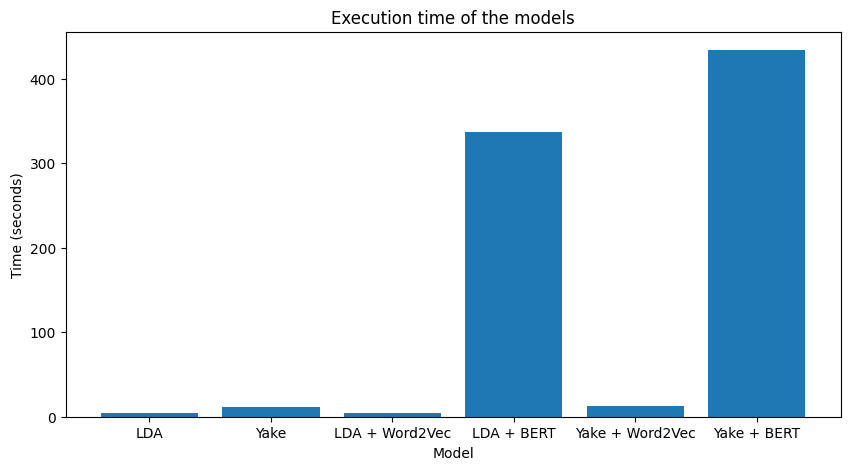

In [32]:
running_times = {
    'LDA': running_time_lda,
    'Yake': running_time_yake,
    'LDA + Word2Vec': running_time_lda_word2vec,
    'LDA + BERT': running_time_lda_bert,
    'Yake + Word2Vec': running_time_yake_word2vec,
    'Yake + BERT': running_time_yake_bert
}


models = list(running_times.keys())
times = list(running_times.values())
  
fig = plt.figure(figsize = (10, 5))
plt.bar(models, times)
plt.xlabel("Model")
plt.ylabel("Time (seconds)")
plt.title("Execution time of the models")
plt.show()